1706 1280


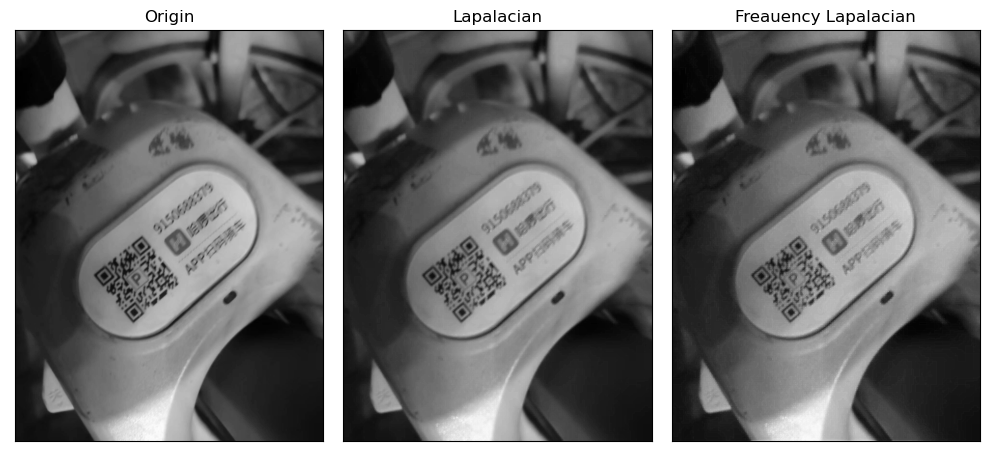

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 8.27：频率域图像锐化（拉普拉斯算子）
def LaplacianFilter(shape):  # 频域 Laplacian 滤波器
    u, v = np.mgrid[-1:1:2.0/shape[0], -1:1:2.0/shape[1]]
    D = np.sqrt(u**2 + v**2)
    kernel = -4 * np.pi**2 * D**2
    return kernel

def imgHPfilter(image, lpTyper="Laplacian"):  #　频域高通滤波
    # (1) 中心化, centralized 2d array f(x,y) * (-1)^(x+y)
    mask = np.ones(image.shape)
    mask[1::2, ::2] = -1
    mask[::2, 1::2] = -1
    fImage = image * mask  # f(x,y) * (-1)^(x+y)
    # (2) 最优 DFT 扩充尺寸, 快速傅里叶变换的尺寸扩充
    rows, cols = image.shape[:2]  # 原始图片的高度和宽度
    rPadded = cv2.getOptimalDFTSize(rows)  # 最优 DFT 扩充尺寸
    cPadded = cv2.getOptimalDFTSize(cols)  # 用于快速傅里叶变换
    # (3) 边缘扩充(补0), 快速傅里叶变换
    dftImage = np.zeros((rPadded, cPadded, 2), np.float32)  # 对原始图像进行边缘扩充
    dftImage[:rows, :cols, 0] = fImage  # 边缘扩充，下侧和右侧补0
    cv2.dft(dftImage, dftImage, cv2.DFT_COMPLEX_OUTPUT)  # 快速傅里叶变换 (rPad, cPad, 2)
    # (4) 构建 频域滤波器传递函数: 以 Laplacian 为例
    LapFilter = LaplacianFilter((rPadded, cPadded))  # 拉普拉斯滤波器
    # (5) 在频率域修改傅里叶变换: 傅里叶变换 点乘 滤波器传递函数
    dftFilter = np.zeros(dftImage.shape, dftImage.dtype)  # 快速傅里叶变换的尺寸(优化尺寸)
    for j in range(2):
        dftFilter[:rPadded, :cPadded, j] = dftImage[:rPadded, :cPadded, j] * LapFilter
    # (6) 对高通傅里叶变换 执行傅里叶逆变换，并只取实部
    idft = np.zeros(dftImage.shape[:2], np.float32)  # 快速傅里叶变换的尺寸(优化尺寸)
    cv2.dft(dftFilter, idft, cv2.DFT_REAL_OUTPUT + cv2.DFT_INVERSE + cv2.DFT_SCALE)
    # (7) 中心化, centralized 2d array g(x,y) * (-1)^(x+y)
    mask2 = np.ones(dftImage.shape[:2])
    mask2[1::2, ::2] = -1
    mask2[::2, 1::2] = -1
    idftCen = idft * mask2  # g(x,y) * (-1)^(x+y)
    # (8) 截取左上角，大小和输入图像相等
    result = np.clip(idftCen, 0, 255)  # 截断函数，将数值限制在 [0,255]
    imgFilter = result.astype(np.uint8)
    imgFilter = imgFilter[:rows, :cols]
    return imgFilter


# (1) 读取原始图像
img = cv2.imread("img/1.jpg", flags=0)  # NASA 月球影像图
rows, cols = img.shape[:2]  # 图片的高度和宽度
print(rows, cols)
# (2) 空间域 拉普拉斯算子 (Laplacian)
# 使用函数 filter2D 实现 Laplace 卷积算子
kernLaplace = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])  # Laplacian kernel
imgLaplace1 = cv2.filter2D(img, -1, kernLaplace, borderType=cv2.BORDER_REFLECT)
# 使用 cv2.Laplacian 实现 Laplace 卷积算子
imgLaplace2 = cv2.Laplacian(img, -1, ksize=3)
imgLapReSpace = cv2.add(img, imgLaplace2)  # 恢复原图像
# (3) 频率域 拉普拉斯算子 (Laplacian)
imgLaplace = imgHPfilter(img, "Laplacian")  # 调用自定义函数 imgHPfilter()
imgLapRe = cv2.add(img, imgLaplace)  # 恢复原图像
plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(img, 'gray'), plt.title("Origin"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(imgLapReSpace, 'gray'), plt.title("Lapalacian"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(imgLapRe, 'gray'), plt.title("Freauency Lapalacian"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()
